# Inference and Validation

Agora que você tem uma rede treinada, pode usá-la para fazer previsões. Isso normalmente é chamado de **inferência**, um termo emprestado das estatísticas. No entanto, as redes neurais tendem a ter um desempenho *muito bom* nos dados de treinamento e não são capazes de generalizar para dados que não foram vistos antes. Isso é chamado de **overfitting** e prejudica o desempenho da inferência. Para testar o overfitting durante o treinamento, medimos o desempenho em dados que não estão no conjunto de treinamento chamado conjunto de **validação**. Evitamos overfitting por meio de regularização, como abandono, enquanto monitoramos o desempenho da validação durante o treinamento. Neste notebook, mostrarei como fazer isso no PyTorch.

Como sempre, vamos começar carregando o conjunto de dados por meio do torchvision. Você aprenderá mais sobre o torchvision e o carregamento de dados posteriormente. Desta vez aproveitaremos o conjunto de testes que você pode obter definindo `train=False` aqui:

```píton
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

O conjunto de teste contém imagens exatamente como o conjunto de treinamento. Normalmente, você verá de 10 a 20% do conjunto de dados original mantido para teste e validação, com o restante sendo usado para treinamento.

In [6]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Aqui vou criar um modelo normal, usando o mesmo da minha solução para a parte 4.

In [7]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

O objetivo da validação é medir o desempenho do modelo em dados que não fazem parte do conjunto de treinamento. O desempenho aqui cabe ao desenvolvedor definir. Normalmente, isso é apenas precisão, a porcentagem de classes que a rede previu corretamente. Outras opções são [precisão e recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) e taxa de erro dos 5 principais. Vamos nos concentrar na precisão aqui. Primeiro, farei uma passagem direta com um lote do conjunto de testes.

In [8]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


Com as probabilidades, podemos obter a classe mais provável usando o método `ps.topk`. Isso retorna os valores mais altos de $k$. Como queremos apenas a classe mais provável, podemos usar `ps.topk(1)`. Isso retorna uma tupla dos principais valores $k$ e dos principais índices $k$. Se o valor mais alto for o quinto elemento, receberemos 4 como índice.

In [9]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5]])


Agora podemos verificar se as classes previstas correspondem aos rótulos. Isso é simples de fazer igualando `top_class` e `labels`, mas temos que ter cuidado com as formas. Aqui `top_class` é um tensor 2D com forma `(64, 1)` enquanto `labels` é 1D com forma `(64)`. Para que a igualdade funcione da maneira que desejamos, `top_class` e `labels` devem ter o mesmo formato.

Se nós fizermos

```píton
equals = top_class == labels
```

`equals` terá a forma `(64, 64)`, experimente você mesmo. O que ele está fazendo é comparar o único elemento em cada linha de `top_class` com cada elemento em `labels`, que retorna 64 valores booleanos Verdadeiro/Falso para cada linha. Para evitar isso, usamos o método `.view` em `labels` para transformá-lo no mesmo formato de `top_class`. (O `*top_class.shape` descompacta os valores da forma, então neste caso é o mesmo que escrever `labels.view(64, 1)`).

In [10]:
equals = top_class == labels.view(*top_class.shape)

Agora precisamos calcular a porcentagem de previsões corretas. `equals` tem valores binários, 0 ou 1. Isso significa que se apenas somarmos todos os valores e dividirmos pelo número de valores, obteremos a porcentagem de previsões corretas. Esta é a mesma operação que calcular a média, então podemos obter a precisão com uma chamada para `torch.mean`. Se fosse assim tão simples. Se você tentar `torch.mean(equals)`, receberá um erro

```
RuntimeError: a média não está implementada para o tipo torch.ByteTensor
```

Isso acontece porque `equals` tem o tipo `torch.ByteTensor` mas `torch.mean` não está implementado para tensores com esse tipo. Portanto, precisaremos converter `equals` em um tensor flutuante. Observe que quando pegamos `torch.mean` ele retorna um tensor escalar, para obter o valor real como um float, precisaremos fazer `accuracy.item()`.

In [11]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 10.9375%


A rede não está treinada, então está fazendo suposições aleatórias e devemos ver uma precisão em torno de 10%. Agora vamos treinar nossa rede e incluir nossa passagem de validação para que possamos medir o desempenho da rede no conjunto de teste. Como não estamos atualizando nossos parâmetros na passagem de validação, podemos acelerar nosso código desativando gradientes usando `torch.no_grad()`:

```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```
>**Exercício:** Implemente o loop de validação abaixo e imprima a precisão total após o loop. Em grande parte, você pode copiar e colar o código acima, mas sugiro digitá-lo porque escrevê-lo você mesmo é essencial para desenvolver a habilidade. Em geral, você sempre aprenderá mais digitando em vez de copiar e colar. Você deve conseguir uma precisão acima de 80%.

In [ ]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        testt_loss = 0
        accuray = 0

        # Desativa o cálculo de gradientes para a validação, economizando memória e computação
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_losses += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
            
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_losses/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_losses/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


        print(f'Accuracy: {accuracy.item()*100}%')


        

In [ ]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 5
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        test_loss = 0
        accuracy = 0

        # Desativa o cálculo de gradientes para a validação, economizando memória e computação
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

        print(f'Accuracy: {accuracy.item()*100}%')


Epoch: 1/5..  Training Loss: 0.517..  Test Loss: 0.474..  Test Accuracy: 0.825
Accuracy: 12951.5625%
Epoch: 2/5..  Training Loss: 0.393..  Test Loss: 0.511..  Test Accuracy: 0.819
Accuracy: 12865.625%
Epoch: 3/5..  Training Loss: 0.359..  Test Loss: 0.388..  Test Accuracy: 0.861
Accuracy: 13510.9375%
Epoch: 4/5..  Training Loss: 0.334..  Test Loss: 0.389..  Test Accuracy: 0.858
Accuracy: 13476.5625%
Epoch: 5/5..  Training Loss: 0.318..  Test Loss: 0.379..  Test Accuracy: 0.864
Accuracy: 13560.9375%


## Overfitting

Se observarmos as perdas de treinamento e validação à medida que treinamos a rede, podemos ver um fenômeno conhecido como overfitting.

<img src='assets/overfitting.png' largura=450px>

A rede aprende cada vez melhor o conjunto de treinamento, resultando em menores perdas de treinamento. No entanto, começa a ter problemas ao generalizar para dados fora do conjunto de treinamento, levando ao aumento da perda de validação. O objetivo final de qualquer modelo de aprendizagem profunda é fazer previsões sobre novos dados, por isso devemos nos esforçar para obter a menor perda de validação possível. Uma opção é usar a versão do modelo com menor perda de validação, aqui aquela em torno de 8 a 10 épocas de treinamento. Esta estratégia é chamada de *early-stopping*. Na prática, você salvaria o modelo com frequência durante o treinamento e, posteriormente, escolheria o modelo com a menor perda de validação.

O método mais comum para reduzir o overfitting (fora da parada antecipada) é o *dropout*, onde descartamos unidades de entrada aleatoriamente. Isto força a rede a compartilhar informações entre pesos, aumentando sua capacidade de generalização para novos dados. Adicionar dropout no PyTorch é simples usando o módulo [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout).

```python
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```

Durante o treinamento queremos usar o dropout para evitar overfitting, mas durante a inferência queremos usar a rede inteira. Portanto, precisamos desligar o dropout durante a validação, teste e sempre que usarmos a rede para fazer previsões. Para fazer isso, você usa `model.eval()`. Isso define o modelo para o modo de avaliação onde a probabilidade de dropout é 0. Você pode ativar o dropout novamente configurando o modelo para o modo de treinamento com `model.train()`. Em geral, o padrão para o loop de validação será semelhante a este, onde você desativa os gradientes, define o modelo para o modo de avaliação, calcula a perda de validação e a métrica e, em seguida, define o modelo novamente para o modo de treinamento.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

> **Exercício:** Adicione dropout ao seu modelo e treine-o novamente no Fashion-MNIST. Veja se você consegue uma menor perda de validação ou maior precisão.

In [13]:
## TODO: Define your model with dropout added
class ClassifierWithDropout(nn.Module):
    def __init__(self):
        super(ClassifierWithDropout, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.2)  # Dropout probability of 20%

    def forward(self, x):
        # Flatten the input tensor
        x = x.view(x.shape[0], -1)
        # Pass through the first fully connected layer with ReLU activation and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # Pass through the second fully connected layer with ReLU activation and dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        # Pass through the third fully connected layer with ReLU activation and dropout
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        # Output layer with log softmax activation
        x = F.log_softmax(self.fc4(x), dim=1)
        return x
    

In [17]:
## TODO: Train your model with dropout, and monitor the training progress with the validation loss and accuracy
model = ClassifierWithDropout()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 5
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        test_loss = 0
        accuracy = 0

        # Desativa o cálculo de gradientes para a validação, economizando memória e computação
        
        model.eval()
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

            #coloca o modelo de volta no modo treinamento
            model.train()
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

        print(f'Accuracy: {accuracy.item()*100}%')


Epoch: 1/5..  Training Loss: 0.604..  Test Loss: 0.464..  Test Accuracy: 0.833
Accuracy: 13082.8125%
Epoch: 2/5..  Training Loss: 0.480..  Test Loss: 0.425..  Test Accuracy: 0.847
Accuracy: 13295.3125%
Epoch: 3/5..  Training Loss: 0.447..  Test Loss: 0.408..  Test Accuracy: 0.854
Accuracy: 13407.8125%
Epoch: 4/5..  Training Loss: 0.433..  Test Loss: 0.437..  Test Accuracy: 0.845
Accuracy: 13270.3125%
Epoch: 5/5..  Training Loss: 0.416..  Test Loss: 0.434..  Test Accuracy: 0.849
Accuracy: 13334.375%


## Inference

Agora que o modelo está treinado, podemos usá-lo para inferência. Já fizemos isso antes, mas agora precisamos lembrar de definir o modelo no modo de inferência com `model.eval()`. Você também deseja desativar a autogradação com o contexto `torch.no_grad()`.

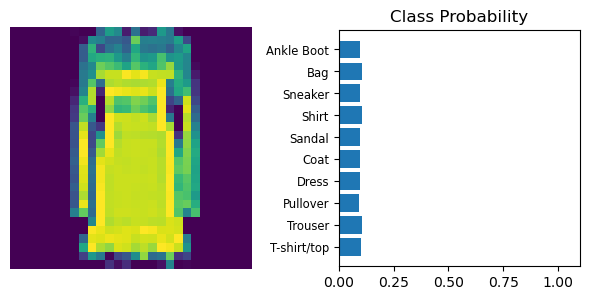

In [21]:
# Import helper module (should be in the repo)
import helper

# Test out your network!
#model = ClassifierWithDropout()
#model.load_state_dict(torch.load('model.pth'))

model.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

## Próximo!

Na próxima parte, mostrarei como salvar seus modelos treinados. Em geral, você não deseja treinar um modelo sempre que precisar. Em vez disso, você treinará uma vez, salvará e carregará o modelo quando quiser treinar mais ou usá-lo para inferência.